In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from scipy.signal import butter, filtfilt, find_peaks, welch
from scipy.spatial.transform import Rotation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GroupKFold
import random
import joblib
from typing import Any
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if "KAGGLE_URL_BASE" in os.environ:
    raw_path = "/kaggle/input/cmi-detect-behavior-with-sensor-data"
else:
    raw_path = "../data/raw"

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# Utils
def get_fft_power(signal: pd.Series):
    fft = np.fft.fft(signal)
    power = np.abs(fft) ** 2
    power = power / 2
    return power


def remove_gravity(df: pd.DataFrame,
                   quat_cols=("rot_x","rot_y","rot_z","rot_w"),
                   acc_cols=("acc_x","acc_y","acc_z"),
                   gravity_mag=9.81):
    """Return a copy with added linear_acc_x/y/z and linear_acc_mag.
       Writes only to rows with valid quaternion; invalid rows keep original accel.
       Expects quat order (x,y,z,w).
    """
    df = df.copy()

    quat_df = df[list(quat_cols)]
    # valid if no NaNs and not all zeros (tolerance for floating)
    valid_mask = (~quat_df.isnull().any(axis=1)) & (~np.isclose(quat_df.values, 0).all(axis=1))
    valid_idx = df.index[valid_mask]

    # By default keep original accel values for invalid rows
    df["linear_acc_x"] = df[acc_cols[0]].astype(float)
    df["linear_acc_y"] = df[acc_cols[1]].astype(float)
    df["linear_acc_z"] = df[acc_cols[2]].astype(float)

    if len(valid_idx) > 0:
        quat_vals = quat_df.loc[valid_idx].to_numpy(dtype=float)     # shape M x 4 (x,y,z,w)
        accel_vals = df.loc[valid_idx, list(acc_cols)].to_numpy(dtype=float)  # shape M x 3

        rotations = Rotation.from_quat(quat_vals)                            # expects [x,y,z,w]
        accel_world = rotations.apply(accel_vals, inverse=True)       # sensor -> world

        gravity = np.array([0.0, 0.0, gravity_mag], dtype=float)
        linear_world = accel_world - gravity                          # linear accel in world frame

        # write results back only to valid rows
        df.loc[valid_idx, "linear_acc_x"] = linear_world[:, 0]
        df.loc[valid_idx, "linear_acc_y"] = linear_world[:, 1]
        df.loc[valid_idx, "linear_acc_z"] = linear_world[:, 2]

    df["linear_acc_mag"] = np.linalg.norm(df[["linear_acc_x","linear_acc_y","linear_acc_z"]].to_numpy(), axis=1)
    return df  
    
def train_model(model: nn.Module, dataloader: DataLoader, n_epochs: int, should_log=True):
    opt = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(n_epochs):
        loss_avg = 0

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss_avg += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

        loss_avg = loss_avg / len(dataloader)
        if (epoch) % 20 == 0 and should_log:
            print(f"{epoch} - loss_avg: {loss_avg}")

def evaulate_model(y_pred, y_true, target_gestures_encoded, encoder: LabelEncoder):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(target_gestures_encoded, torch.Tensor):
        target_gestures_encoded = target_gestures_encoded.cpu().numpy()

    conf_matrix_result = confusion_matrix(y_true, y_pred)
    clsf_report_result = pd.DataFrame(classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True, zero_division=0)).T

    y_true_binary = np.isin(y_true, target_gestures_encoded)
    y_pred_binary = np.isin(y_pred, target_gestures_encoded)
    f1_binary = f1_score(y_true_binary, y_pred_binary, average="binary", zero_division=0)

    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    competition_evaluation = 0.5 * f1_binary + 0.5 * f1_macro

    return {
        "confusion_matrix": conf_matrix_result,
        "classification_report": clsf_report_result,
        "f1_binary": f1_binary,
        "f1_macro": f1_macro,
        "competition_evaluation": competition_evaluation,
    }


def plot_cm(cm: np.ndarray, classes: list[str]) -> None:
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=80)
    plt.title("Confusion matrix")


def get_avg_fold(folds_score: list[dict[str, Any]]):
    f1_binary_avg = np.mean([fold["f1_binary"] for fold in folds_score])
    f1_macro_avg = np.mean([fold["f1_macro"] for fold in folds_score])
    competition_avg = np.mean([fold["competition_evaluation"] for fold in folds_score])
    confusion_matrix_avg = np.mean([fold["confusion_matrix"] for fold in folds_score], axis=0)

    reports = [fold["classification_report"] for fold in folds_score]
    reports_avg = pd.concat(reports).groupby(level=0).mean()

    return {
        "f1_binary": f1_binary_avg,
        "f1_macro": f1_macro_avg,
        "competition_evaluation": competition_avg,
        "confusion_matrix": confusion_matrix_avg,
        "classification_report": reports_avg,
    }

In [ ]:
# Clean DataFrame
def get_counts(df) -> pd.DataFrame:
    return df.groupby("sequence_id")["sequence_counter"].max() - df.groupby("sequence_id")["sequence_counter"].min() + 1


def log_dropped(len_before, len_after, description):
    dropped = len_before - len_after
    perc_dropped = (dropped / len_before) * 100
    print(f"[{description}] Remaining: {len_after}/{len_before} " f"(-{dropped}, {perc_dropped:.1f}% dropped)")


def normalize_sequence_count(df: pd.DataFrame, group_col: str = "sequence_id", seq_counter_col: str = "sequence_counter") -> pd.DataFrame:
    """
    Adds gesture_counter_length with a value of the length of the elmeents of teh array
    it gets maximum + 1, so it is the execlusive end
    """
    out_groups = []
    max_count = get_counts(df).max()

    for _, group in df.groupby(group_col, sort=False):
        g = group.copy()
        # compute length for this group
        group_count = g[seq_counter_col].max() - g[seq_counter_col].min() + 1
        needed = max_count - group_count

        if needed > 0:
            last = g.iloc[-1].copy()
            repeats = pd.DataFrame([last] * needed)

            # continue the sequence_counter for appended rows
            start = int(last[seq_counter_col])
            repeats[seq_counter_col] = range(start + 1, start + 1 + needed)

            g = pd.concat([g, repeats], ignore_index=True)
5
        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)


def clean_df(df: pd.DataFrame, drop_rot_na=True, drop_thm_na=True, min_gesture_count=28, max_gesture_count=35):
    """
    min_gesture_count = 28, max_gesture_count = 35 was the current best performing
    put as -1 to not do it
    """
    df = df.copy()
    df = df.ffill().bfill().fillna(0)
    non_target_gestures = df[df["sequence_type"] == "Non-Target"]["gesture"].unique()
    target_gestures = df[df["sequence_type"] == "Target"]["gesture"].unique()

    filtered_df = df[df["phase"] == "Gesture"]
    filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

    curr_len = len(filtered_df)
    if drop_rot_na:
        # drop na rotation
        bad_seq_id = df[df["rot_w"].isnull()]["sequence_id"].unique()
        bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
        filtered_df = filtered_df[~bad_seq_mask]
        
        log_dropped(curr_len, len(filtered_df), "rot_na")
        curr_len = len(filtered_df)

    if drop_thm_na:
        for i in range(1, 6):
            bad_seq_id = df[df[f"thm_{i}"].isnull()]["sequence_id"].unique()
            bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
            filtered_df = filtered_df[~bad_seq_mask]


        log_dropped(curr_len, len(filtered_df), "thm_na")
        curr_len = len(filtered_df)

    # drop outliers in terms of count
    if min_gesture_count != -1 and max_gesture_count != -1:
        gesture_counts = get_counts(filtered_df)
        valid_mask = (gesture_counts >= min_gesture_count) & (gesture_counts <= max_gesture_count)
        valid_idx = gesture_counts[valid_mask].index
        filtered_df = filtered_df[filtered_df["sequence_id"].isin(valid_idx)]


        log_dropped(curr_len, len(filtered_df), "gesture_len outliers")
        curr_len = len(filtered_df)

    return filtered_df, target_gestures


In [4]:
# Feature Engineer
def rotation_feature_engineer(df: pd.DataFrame):
    df = df.copy()
    quat_arr = df[["rot_x", "rot_y", "rot_z", "rot_w"]].values
    num_samples = quat_arr.shape[0]
    angular_vel = np.zeros([num_samples, 3])

    rotation_object = Rotation.from_quat(quat_arr)
    rotation_vectors = rotation_object.as_rotvec()

    df["rotvec_x"] = rotation_vectors[:, 0]
    df["rotvec_y"] = rotation_vectors[:, 1]
    df["rotvec_z"] = rotation_vectors[:, 2]
    df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

    dt = 1 / 200
    num_samples = len(df)

    if num_samples > 1:
        q_current = quat_arr[:-1]  # t0 to t_{n-2}
        q_next = quat_arr[1:]  # t1 to t_{n-1}

        rot_curr = Rotation.from_quat(q_current)
        rot_next = Rotation.from_quat(q_next)
        delta_rot = rot_curr.inv() * rot_next

        angular_vel[1:] = delta_rot.as_rotvec() / dt

    df["angular_vel_x"] = angular_vel[:, 0]
    df["angular_vel_y"] = angular_vel[:, 1]
    df["angular_vel_z"] = angular_vel[:, 2]
    df["angular_speed"] = np.linalg.norm(angular_vel, axis=1)

    return df


def accelrometer_feature_engineer(df: pd.DataFrame):
    cols_of_interest = ["linear_acc_x", "linear_acc_y", "linear_acc_z"]

    for col in cols_of_interest:
        df[f"fft_{col}"] = df.groupby("sequence_id")[col].transform(get_fft_power)

    df["acc_mag"] = np.linalg.norm([df["linear_acc_x"], df["linear_acc_y"], df["linear_acc_z"]], axis=0)
    df["jerk_acc_x"] = df.groupby("sequence_id")["linear_acc_x"].diff().fillna(0)
    df["jerk_acc_y"] = df.groupby("sequence_id")["linear_acc_y"].diff().fillna(0)
    df["jerk_acc_z"] = df.groupby("sequence_id")["linear_acc_z"].diff().fillna(0)

    return df

In [5]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_2_v26,tof_3_v17,tof_4_v5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,122.0,57.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,124.0,68.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,133.0,97.0,107.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,151.0,113.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,207.0,121.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,62.0,219.0,93.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,58.0,216.0,82.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,56.0,208.0,83.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,59.0,210.0,91.0,1,30,0,1,186.0,55,30.0


In [6]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False) #, min_gesture_count=-1)
cleaned_df = remove_gravity(cleaned_df)
cleaned_df = normalize_sequence_count(cleaned_df)
# cleaned_df = cleaned_df[cleaned_df['gesture'].isin(['Neck - scratch', 'Neck - pinch skin'])]

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 255817/255817 (-0, 0.0% dropped)
[gesture_len outliers] Remaining: 224292/255817 (-31525, 12.3% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,angular_vel_y,angular_vel_z,angular_speed,fft_linear_acc_x,fft_linear_acc_y,fft_linear_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,0.000000,4184.443229,9229.321542,708.751281,5.444538,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,3.675529,0.866171,5.950586,2.654035,57.131623,13.107290,5.252884,0.106349,-0.080353,0.297627
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-3.481096,-6.557898,7.828564,29.612720,35.332845,13.417370,5.477043,0.644451,0.673234,0.322615
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-16.758832,-4.311011,17.631206,116.815096,7.849105,10.571504,4.462832,0.189992,-1.107950,-0.266803
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-4.452315,-0.930412,4.551592,3.985886,2.641482,4.756892,4.607620,-0.723718,-0.259408,0.076626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254270,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,5.373453,3.841997,6.794645,6.685069,11.418325,12.432999,4.403618,-0.805551,1.090092,1.488263
254271,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,-3.354712,-0.168707,3.405086,6.206899,2.100370,1.745530,4.999833,-0.336104,0.571239,0.397882
254272,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,2.083330,31.605432,16.233876,4.999833,0.000000,0.000000,0.000000
254273,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,2.294327,0.366011,12.050606,4.999833,0.000000,0.000000,0.000000


In [7]:
feautures_of_interest = [
    "linear_acc_x",
    "linear_acc_y",
    "linear_acc_z",
    "fft_linear_acc_x",
    "fft_linear_acc_y",
    "fft_linear_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_vel_x",
    "angular_vel_y",
    "angular_vel_z",
    "angular_speed",
    "tof_1_v20",
    "thm_2",
    "thm_4",
    "thm_5",
]

sequence_groups = cleaned_df.groupby('sequence_id')
target_df = sequence_groups['gesture'].first()
encoder = LabelEncoder().fit(target_df)


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

target_np = encoder.transform(target_df).astype(np.int64) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_df))

features_full_seq.shape, target_tensor.shape

(torch.Size([7265, 22, 35]), torch.Size([7265]))

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x * (1 + noise)

        return x


class SEBlock(nn.Module):
    def __init__(self, in_channels, r=8):
        super().__init__()
        # takes input of shape BxCxT
        # purpose is to squeeze the temporal dimension and excite the Channels dimension
        self.excitation_net = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        # x: [B x C x T]
        squeezed = torch.mean(x, dim=2)
        weights = self.excitation_net(squeezed).unsqueeze(-1)  # B x C x 1
        out = x * weights
        return out


class AttentionBlock(nn.Module):
    def __init__(self, in_channels, r=8):
        super().__init__()
        self.score_generator = nn.Sequential(
            nn.Linear(in_channels, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor):
        """
        expected x shape: B x T x C
        """
        scores = self.score_generator(x)  # Shape: (B, T, 1)
        out = torch.sum(scores * x, dim=1)
        return out


class ReSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            #
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.se_block = SEBlock(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut_layer = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False), nn.BatchNorm1d(out_channels), nn.Dropout1d(0.1))
        else:
            self.shortcut_layer = nn.Sequential(
                nn.Identity(),
            )

        self.final_relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut_layer(x)
        out = self.conv_block(x)
        out = self.se_block(out)

        out += shortcut
        out = self.final_relu(out)

        return out


class LSTMBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, layer_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.lstm_layer = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: batch x seq x features
        """
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm_layer(x, (h0, c0))  # B x T x 2 * hidden_dim
        return out


class SimpleModel(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.noise_layer = nn.Sequential(
            GaussianNoise(stddev=0.06),
        )
        self.res_connection = nn.Sequential(
            ReSEBlock(in_channels, 32, stride=2),
            # ReSEBlock(32, 64, stride=2),
        )
        self.lstm_net = nn.Sequential(
            LSTMBlock(32, hidden_dim=48, layer_dim=2),
        )

        self.temporal_attention = nn.Sequential(
            AttentionBlock(in_channels=2 * 48),
        )

        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2 * 48, 48), nn.ReLU(), nn.Linear(48, n_classes))

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.noise_layer(x)
        out: torch.Tensor = self.res_connection(x)  # B x F x (T // n)
        out = out.transpose(2, 1)  # B x (T // n) x F
        out = self.lstm_net(out)  # B x (T // n) x (hidden_dim * 2)
        out = self.temporal_attention(out)
        y_pred = self.fc(out)

        return y_pred


dummy_input = torch.rand(64, 15, 35)  # B x F x T
dummy_model = SimpleModel(in_channels=15, n_classes=len(encoder.classes_))
dummy_model(dummy_input).shape
# dummy_attention_model = AttentionBlock(35)
# dummy_attention_model(dummy_input).shape # expected output: 64 x 35

torch.Size([64, 9])

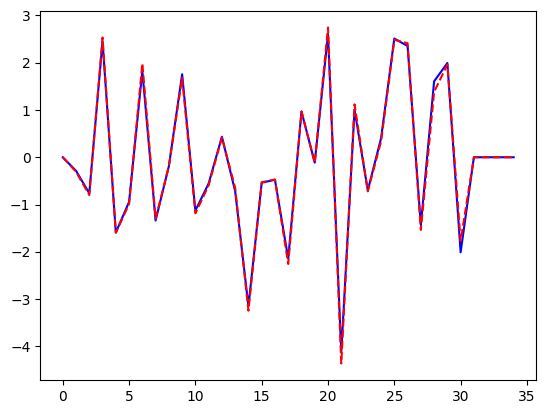

In [345]:
noise_block = GaussianNoise(0.06)
sample = features_full_seq[21, 7, :]
sample_noised = noise_block(sample)

plt.plot(range(len(sample)), sample, 'b')
plt.plot(range(len(sample)), sample_noised, 'r--')

In [ ]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 5
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 64
n_epochs = 70

test_subjects = []
lgbm_folds_score = []
cnn_folds_score = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    if fold >= 3:
        break
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = SimpleModel(in_channels=n_features, n_classes=len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True)
    
    model.eval()
    y_pred = torch.argmax(model(X_test.to(device)), dim=1)
    score_dashboard = evaulate_model(y_pred.to(device), y_test.to(device), target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)


------FOLD 1/5------

0 - loss_avg: 1.5988231081029642


CNN FOLD SCORE
macro: 0.473, binary: 1.000, competition: 0.737


,precision,recall,f1-score,support
Above ear - pull hair,0.596215,0.581542,0.585743,117.000000
Cheek - pinch skin,0.392974,0.370529,0.380522,121.500000
Eyebrow - pull hair,0.284752,0.230505,0.252098,123.750000
Eyelash - pull hair,0.347333,0.400668,0.370263,120.500000
Forehead - pull hairline,0.474569,0.474921,0.469025,118.500000
Forehead - scratch,0.524390,0.579548,0.545300,120.750000
Neck - pinch skin,0.352774,0.307226,0.326476,119.500000
Neck - scratch,0.427401,0.403110,0.410335,117.500000
Write name on leg,0.910776,0.930618,0.919852,495.000000
accuracy,0.591806,0.591806,0.591806,0.591806


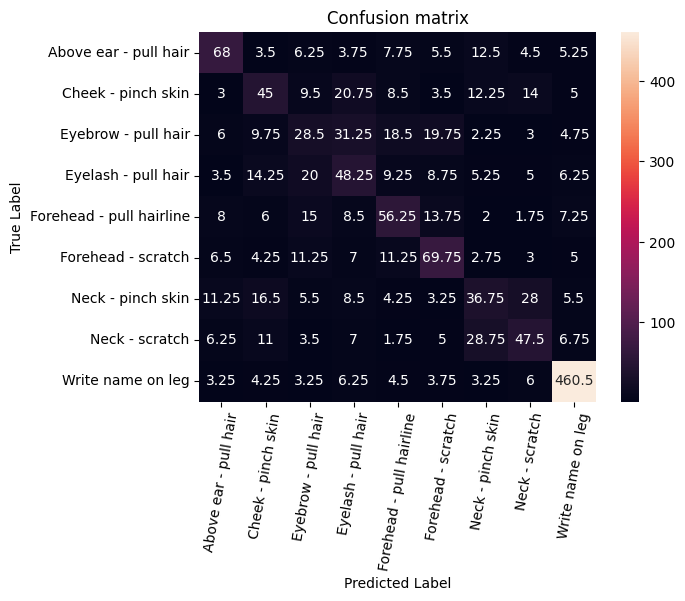

In [11]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]